In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff
# import cufflinks as cf


# Problem Statement

The Googple Play Store dataset is crawled by comnunity, which contains two parts. 
* The 1st part has app name, category, pricing, installs, ..
* The 2nd part contains some review comments for those apps

I chose this dataset mostly because I'm curious about how the app market look like.
The dataset only contains a handful of data point, and it's not realistic to build a model base on that, so I would not try to build a model to predict anything below.

Below, I highlight some aspects of the dataset, which includes
* App distribution base on pricing

The thing that I like most about this is actually Plotly within Notebook.

## Review the data

At the beginning, I need to clean up the data a lot because those data is crawled from the actual Google App Store, not via any API.

* The cleaning includes normalize app size into bytes from Megabyte
* Removing + sign in number of Installs. At here, we don't have the exact number for the number of install the app, I learn from another kernel that applying the log function to wide range data would reduce the range of the output, thus would help the analysis.

In [3]:
df = pd.read_csv('google-play-store-apps/googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
# keep one sample data for testing
df_test = df[df['App'] == 'Monash Uni Low FODMAP Diet'].head(1).copy()
df_test

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2243,Monash Uni Low FODMAP Diet,MEDICAL,4.2,1135,12M,"100,000+",Paid,$9.00,Everyone,Medical,"July 16, 2018",2.0.7,4.0 and up


# Cleaning data

In [5]:
# clean the data
df.drop_duplicates(subset='App', inplace=True)
df = df[~df['Android Ver'].isna()]

print('Number of apps in the dataset: ', len(df))
df.sample(5)

Number of apps in the dataset:  9657


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1447,"Viva Decora - Decoration, Photos, Architecture...",HOUSE_AND_HOME,4.8,3167,7.5M,"100,000+",Free,0,Everyone,House & Home,"August 3, 2018",2.0.0,5.0 and up
9730,Lean EQ,BUSINESS,NaN,6,10M,10+,Paid,$89.99,Everyone,Business,"February 14, 2017",1.0,4.1 and up
1127,Stock Quote,FINANCE,4.1,4344,4.5M,"500,000+",Free,0,Everyone,Finance,"July 30, 2018",3.6.2,4.0 and up
3365,ZenUI Launcher,PERSONALIZATION,4.7,1141545,15M,"50,000,000+",Free,0,Everyone,Personalization,"July 31, 2018",Varies with device,Varies with device
2102,Car Racing game for Kids - Beepzz Dogs 🐕,FAMILY,4.4,131,48M,"100,000+",Free,0,Everyone,Racing;Action & Adventure,"June 13, 2018",1.1.1,4.2 and up


In [6]:
# Remove + and , sign then convert to integer
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', ''))
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', ''))
df['Installs'] = df['Installs'].apply(lambda x: int(x))

In [7]:
# Convert to integer
df['Reviews'] = df['Reviews'].apply(lambda x: int(x))

In [8]:
# Convert to float
df['Price'] = df['Price'].apply(lambda x: x.replace('$', ''))
df['Price'] = df['Price'].apply(lambda x: float(x))

In [9]:
df['Size'] = df['Size'].apply(lambda x: x.replace('Varies with device', 'NaN'))
df['Size'] = df['Size'].apply(lambda x: x.replace('M', ''))
df['Size'] = df['Size'].apply(lambda x: float(x.replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(x))

In [10]:
df_clean = df.copy()
df_clean['Rating'].dropna(inplace=True)
df_clean['Size'].dropna(inplace=True)

df_clean = df_clean[df_clean['Installs'] > 0]
df_clean['Installs'].dropna(inplace=True)
df_clean['Installs_Log'] = np.log(df_clean['Installs'])

df_clean = df_clean[df_clean['Reviews'] > 0]
df_clean['Reviews'].dropna(inplace=True)
df_clean['Reviews_Log'] = np.log(df_clean['Reviews'])

df_clean['Type'].dropna(inplace=True)

In [11]:
# some testing
df_assert = df_clean[df_clean['App'] == 'Monash Uni Low FODMAP Diet']
assert(df_assert['Rating'].item() == df_test['Rating'].item())
assert(df_assert['Reviews'].item() == 1135)
assert(df_assert['Size'].item() == 12.0)
assert(df_assert['Installs'].item() == 100000) 
assert(df_assert['Type'].item() == 'Paid')

# EDA

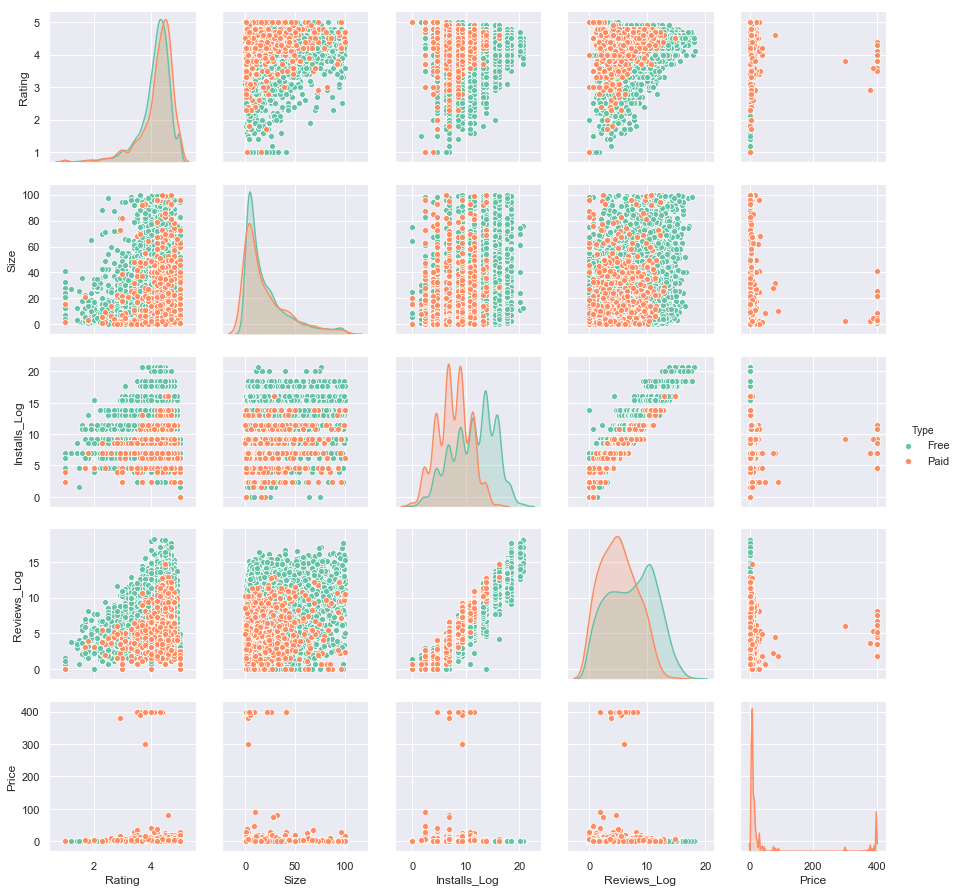

In [12]:
sns.pairplot(data=df_clean[['Rating', 
                            'Size', 
                            'Installs_Log', 
                            'Reviews_Log', 
                            'Type', 
                            'Price']], hue='Type', palette='Set2')

## Breakdown by categories

Looking at categories, I can see that Family, Games and Tools categories accounts for 40% of the dataset. However, this is not necessary the same for the whole market.

* Family accounts for 20% total apps
* Game and Tools follow with ~10% each

That means there are lot of demands and competitions in these categories.

Looking deeper into apps in the FAMILY category, it turns out that most of the apps listed there are also some kind of GAMES for children.

**Finding**: CHILDREN are KING customers!

In [13]:
apps_category = df_clean['Category'].value_counts()
data = [go.Pie(
    labels = apps_category.index,
    values = apps_category.values,
    hoverinfo = 'label+value'
)]

plotly.offline.iplot(data)

In [17]:
df_clean[df_clean['Category'] == 'FAMILY'].sample(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_Log,Reviews_Log
5570,AR Toys: Playground Sandbox | Remote Car,FAMILY,4.5,153,NaN,10000,Free,0.00,Everyone,Simulation,"August 3, 2018",0.8,7.0 and up,9.210340,5.030438
9272,EF English Live Business,FAMILY,3.6,496,14.0,100000,Free,0.00,Everyone,Education,"May 4, 2018",2.0.1,4.4 and up,11.512925,6.206576
9537,Bus Driver 3D: Hill Station,FAMILY,4.3,31705,49.0,5000000,Free,0.00,Everyone,Simulation,"November 6, 2017",1.7,4.1 and up,15.424948,10.364230
6202,LEGO ® Batman: Beyond Gotham,FAMILY,4.1,10758,8.0,100000,Paid,4.99,Everyone 10+,Adventure;Action & Adventure,"December 15, 2015",Varies with device,4.0.3 and up,11.512925,9.283405
2082,Montessori Preschool,FAMILY,3.9,237,26.0,100000,Free,0.00,Everyone,Education;Education,"July 12, 2018",1.7.2,4.1 and up,11.512925,5.468060
8780,Dr. Panda's Swimming Pool,FAMILY,4.4,2311,9.3,100000,Paid,1.99,Everyone,Casual;Pretend Play,"January 15, 2015",1.01,4.0 and up,11.512925,7.745436
9823,Esto Es Guerra TVN,FAMILY,4.5,1303,13.0,100000,Free,0.00,Everyone,Entertainment,"July 24, 2018",1.7.2,4.1 and up,11.512925,7.172425
7482,Tic Tac CK,FAMILY,5.0,3,13.0,10,Free,0.00,Everyone,Puzzle,"July 3, 2018",1.0,4.0.3 and up,2.302585,1.098612
4723,Fantasy Squad W,FAMILY,4.3,2142,47.0,50000,Free,0.00,Everyone 10+,Role Playing,"April 16, 2018",1.5.4,4.1 and up,10.819778,7.669495
4689,Mod GTA V for MCPE,FAMILY,3.3,4288,10.0,500000,Free,0.00,Everyone,Entertainment,"April 23, 2018",1.2.3.4.5,4.0.3 and up,13.122363,8.363576


## Overall Ratings

Let take a look at app ratings.

In [18]:
print('Average rating of apps: ', df_clean['Rating'].mean())

Average rating of apps:  4.1731754942640995


It's a bit suprise that the average app rating is ~ 4.2 - quite high.

Comparing this number with the another site https://www.appbrain.com/stats/android-app-ratings turn out to be truth for the overall market.

That also means if I want to make my app standout of the crowd, it much be higher than this, probably >= 4.5.
I will also more picky in the future when I'm looking for an app as now I know, 4.2 is the average.

In [19]:
data = [go.Histogram(
    x = df_clean['Rating'],
    xbins = {'start': 1, 'size': 0.1, 'end': 5}
)]
plotly.offline.iplot(data)

## Categories vs Rating

Now I would like to look deeper into each category to see average rating in each category and the differences between free apps vs paid apps.

Looking at those violin charts, I can see that there is not much difference between categories or free / paid at all. However, there are a clear distinction between Free Apps vs Paid Apps in the Magazine and Social categories. 
Looking deeper into them, it turns out that there are so small number of paid apps. 

* In case of Magazine Categories, there are two apps, they do not have a lot of Installs. Customers of those apps seems retired soldiers, which seems loyal and rate high for it.
* In case of Social category, there are also two apps, and they have so much issues. 

**Finding**: The average rating across apps are quite the same. That would lead to two hypotheses
* Free Apps are as high quality as Paid Apps. It makes sense, especially big companies like Google, Facebook offer free apps and earn money from selling data. Also, there are many apps listed as free, but they actually offer In-App purchase, meaning that they are not pure Free.
* OR Customers are more fair when rating for Free Apps vs Paid Apps. Meaning they has different expectation for Free Apps, knowing that they are using something for free.

In [19]:
groups = df_clean.groupby('Category').filter(lambda x: len(x) > 200).reset_index()

layout = {
    'title': 'App rating across major categories',
    'xaxis': { 'tickangle': -40 },
    'yaxis': { 'title': 'Rating' },
    'plot_bgcolor': 'rgb(250, 250, 250)'
}

data = []
for i, category in enumerate(list(set(groups.Category))):
    data.append({'y': df_clean.loc[(df_clean.Category == category) & (df_clean.Type == 'Free')]['Rating'],
                 'type': 'violin',
                 'name': category,
                 'side': 'positive',
                 'showlegend': True,
                 'meanline': { "visible": True } })
    data.append({'y': df_clean.loc[(df_clean.Category == category) & (df_clean.Type == 'Paid')]['Rating'],
                 'type': 'violin',
                 'name': category,
                 'side': 'negative',
                 'showlegend': True,
                 'meanline': { "visible": True } })

plotly.offline.iplot({'data': data, 'layout': layout})

In [35]:
df_clean[(df_clean['Category'] == 'NEWS_AND_MAGAZINES') & (df_clean['Type'] == 'Paid')].sample(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_Log,Reviews_Log
9828,Égalité et Réconciliation,NEWS_AND_MAGAZINES,4.9,58,3.8,500,Paid,2.99,Everyone,News & Magazines,"May 26, 2018",1.1.1,5.0 and up,6.214608,4.060443
4491,"Q Alerts: QAnon Drop Notifications, Research +++",NEWS_AND_MAGAZINES,4.7,143,26.0,5000,Paid,0.99,Mature 17+,News & Magazines,"July 26, 2018",4.1.10,4.1 and up,8.517193,4.962845


In [33]:
df_clean[(df_clean['Category'] == 'SOCIAL') & (df_clean['Type'] == 'Free')].sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_Log,Reviews_Log
9194,UP EB Bill Payment & Details,SOCIAL,5.0,3,2.4,50,Free,0.0,Teen,Social,"July 11, 2018",2.0,4.0 and up,3.912023,1.098612
9512,Hum Ek Hain 2.02,SOCIAL,5.0,2,1.8,10,Free,0.0,Teen,Social,"March 18, 2018",1.0,5.0 and up,2.302585,0.693147
10212,"Stickers for Imo, fb, whatsapp",SOCIAL,4.4,214,8.7,10000,Free,0.0,Teen,Social,"October 23, 2016",1.0.0.2,2.3 and up,9.210340,5.365976
10224,Stickers for Facebook,SOCIAL,4.3,11066,10.0,1000000,Free,0.0,Everyone,Social,"March 13, 2018",1.4,4.4 and up,13.815511,9.311633
8334,Noticias DF,SOCIAL,NaN,2,2.3,1000,Free,0.0,Everyone,Social,"May 25, 2015",1.0,2.3 and up,6.907755,0.693147


# Size vs Rating

* Most of apps are less than 10 MB
* Highest rating apps - close to 5 - are also less than 20 MB

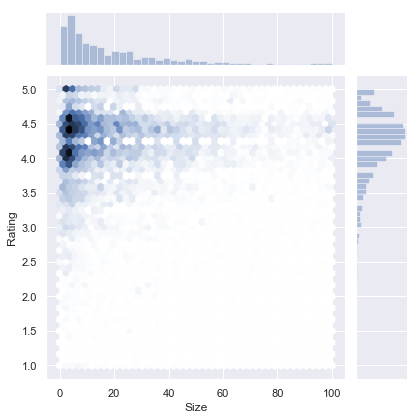

In [21]:
sns.jointplot(df_clean['Size'], df_clean['Rating'], kind='hex')

## Pricing

The most interesting part is looking Pricing. MEDICAL and PERSONALIZATION stands out in term of percentage of Paid Apps, ~ 20%. While other categories has less than 10% Paid Apps.

Because there are more apps in Family categories, the absolute number of paid apps in the Family category is also higher.

**Finding**: 
* When it comes to healthcare, people are more likely to pay money. And App Dev knows that!!!
* People are also love Fashion for their phone - Personalization category. People love their phone so much!

In [22]:
df_clean['Price_Type'] = 0
df_clean.loc[df_clean['Type'] == 'Paid', 'Price_Type'] = 1
df_price_type = df_clean.groupby('Category')[['Price_Type', 'App']]\
                        .agg({'App': 'count', 'Price_Type': 'sum'}, as_index=False)\
                        .rename(columns={'App': 'Count', 'Price_Type': 'Paid_Count'})

df_price_type['Perc_Paid'] = np.round(100 * df_price_type['Paid_Count'] / df_price_type['Count'], 2)
df_price_type['Perc_Free'] = 100 - df_price_type['Perc_Paid']
df_price_type['Total'] = 100
df_price_type.reset_index(inplace=True)
df_price_type = df_price_type[df_price_type['Count'] > 200]
df_price_type = df_price_type.sort_values(by=['Perc_Paid', 'Count'], ascending=[False, False])
df_price_type.head()

,Category,Count,Paid_Count,Perc_Paid,Perc_Free,Total
20,MEDICAL,333,75,22.52,77.48,100
23,PERSONALIZATION,343,70,20.41,79.59,100
11,FAMILY,1762,169,9.59,90.41,100
29,TOOLS,784,70,8.93,91.07,100
6,COMMUNICATION,286,24,8.39,91.61,100


In [23]:
paid_apps = go.Bar(
    x=df_price_type['Category'],
    y=df_price_type['Perc_Paid'],
    name='% Paid Apps'
)
free_apps = go.Bar(
    x=df_price_type['Category'],
    y=df_price_type['Perc_Free'],
    name='% Free Apps'
)

data = [paid_apps, free_apps]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [24]:
total_apps = go.Bar(
    x=df_price_type['Category'],
    y=df_price_type['Count'],
    name='Total Apps'
)
paid_apps = go.Bar(
    x=df_price_type['Category'],
    y=df_price_type['Paid_Count'],
    name='Paid Apps'
)

data = [total_apps, paid_apps]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [22]:
# MEDICAL Paid Apps 
df_clean[(df_clean['Type'] == 'Paid') & (df_clean['Category'] == 'MEDICAL')].sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_Log,Reviews_Log
2253,Vargo Anesthesia Mega App,MEDICAL,4.6,92,32.0,1000,Paid,79.99,Everyone,Medical,"June 18, 2018",19.0,4.0.3 and up,6.907755,4.521789
2249,MommyMeds,MEDICAL,3.2,45,21.0,5000,Paid,3.99,Everyone,Medical,"November 15, 2017",2.0.1,6.0 and up,8.517193,3.806662
2272,AnatomyMapp,MEDICAL,4.1,80,48.0,5000,Paid,14.99,Everyone,Medical,"November 5, 2013",1.0,3.0 and up,8.517193,4.382027
2414,LTC AS Legal,MEDICAL,4.0,6,1.3,100,Paid,39.99,Everyone,Medical,"April 4, 2018",3.0.1,4.1 and up,4.605170,1.791759
2255,Muscle Trigger Point Anatomy,MEDICAL,4.4,1361,33.0,50000,Paid,2.99,Everyone,Medical,"July 17, 2018",2.4.4,4.0.3 and up,10.819778,7.215975


In [23]:
# PERSONALIZATION Paid Apps
df_clean[(df_clean['Type'] == 'Paid') & (df_clean['Category'] == 'PERSONALIZATION')].sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_Log,Reviews_Log
4769,Light X - Icon Pack,PERSONALIZATION,4.6,252,24.000,10000,Paid,0.99,Everyone,Personalization,"June 13, 2018",1.6.1,4.1 and up,9.210340,5.529429
9876,EU Flags Live Wallpaper,PERSONALIZATION,4.3,444,12.000,10000,Paid,0.99,Everyone,Personalization,"November 18, 2013",1.95,2.1 and up,9.210340,6.095825
4403,Dark Infusion Substratum Theme for Android N & O,PERSONALIZATION,4.8,133,59.000,1000,Paid,2.49,Everyone,Personalization,"August 3, 2018",15.6,7.0 and up,6.907755,4.890349
8590,MultiPicture Live Wallpaper dn,PERSONALIZATION,4.3,505,0.288,10000,Paid,1.99,Everyone,Personalization,"February 10, 2013",0.6.11,2.1 and up,9.210340,6.224558
4457,Pacify Exceed (Android P) - Theme for Xperia™,PERSONALIZATION,NaN,5,1.900,10,Paid,1.49,Everyone,Personalization,"July 2, 2018",1.2.A.Exceed.Paid,6.0 and up,2.302585,1.609438


## Installs vs Rating

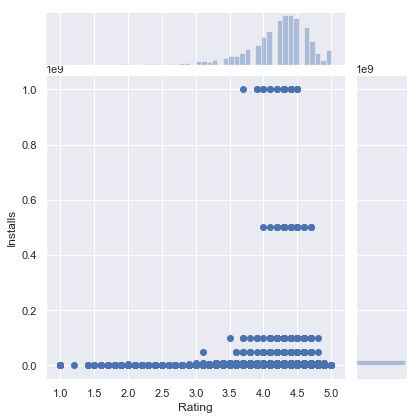

In [25]:
sns.jointplot(x='Rating', y='Installs', data=df_clean)

**Finding**: We can see that popular apps with more intalls are more likely to receive higher ratings than apps with less downloads. Those apps are super apps and communications apps from big companies like Google, Facebook, ...

In [26]:
df_clean[df_clean['Installs'] >= 1e9].sort_values(by=['Rating'], ascending=False).head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Installs_Log,Reviews_Log,Price_Type
2545,Instagram,SOCIAL,4.5,66577313,NaN,1000000000,Free,0.0,Teen,Social,"July 31, 2018",Varies with device,Varies with device,20.723266,18.013874,0
2808,Google Photos,PHOTOGRAPHY,4.5,10858556,NaN,1000000000,Free,0.0,Everyone,Photography,"August 6, 2018",Varies with device,Varies with device,20.723266,16.200464,0
1654,Subway Surfers,GAME,4.5,27722264,76.0,1000000000,Free,0.0,Everyone 10+,Arcade,"July 12, 2018",1.90.0,4.1 and up,20.723266,17.137746,0
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,NaN,1000000000,Free,0.0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device,20.723266,18.051345,0
3234,Google,TOOLS,4.4,8033493,NaN,1000000000,Free,0.0,Everyone,Tools,"August 3, 2018",Varies with device,Varies with device,20.723266,15.899130,0


## Installs vs Reviews

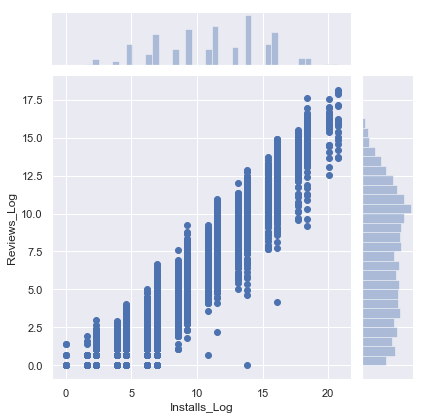

In [27]:
sns.jointplot(x='Installs_Log', y='Reviews_Log', data=df_clean)

**Finding**: The correlation between Installs and Reviews is quite clear. The more downloads an app has, the more Reviews it might get.

## Predictions

Now let see the correlation between major features including: Rating, Size, Installs, Reviews and Price.

In [28]:
df_model = df_clean[['Rating', 'Size', 'Installs_Log', 'Price', 'Reviews_Log']]
df_model = df_model.dropna(how='any')

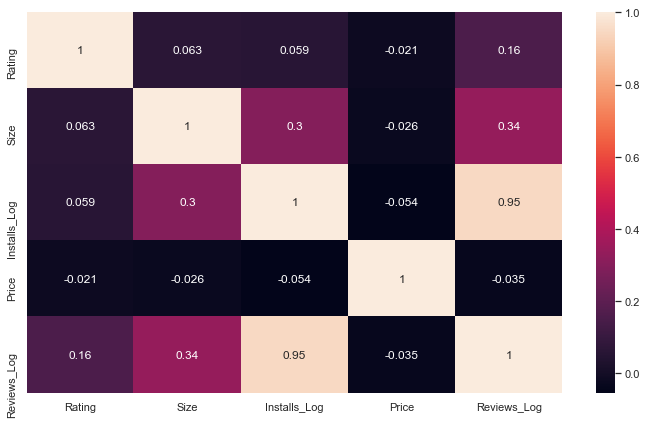

In [34]:
plt.figure(figsize=(12,7))
corr = df_model.corr()
sns.heatmap(corr, annot=True)

**Finding** 
* Again this matrix show a strong correlation between Installs and Reviews. 
* Furthermore, Rating is positively correlated with Installs, Reviews, Size

## Summary
* The market for Games including Education Games for Children are huge.
* App Quality in general is quite high. Possiblity backed by Free App with In App Purchase.
* People are willing to pay when it comes to their Health or customize their apps more beautiful.


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

/Users/antran/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [31]:
X = df_model.drop(columns=['Rating'])
y = df_model['Rating']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

l_model = LinearRegression()
l_model.fit(X_train, y_train)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred_l = l_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

In [33]:
print('MSE for Linear Regression', metrics.mean_squared_error(y_test, y_pred_l))
print('MSE for Random Forest', metrics.mean_squared_error(y_test, y_pred_rf))

MSE for Linear Regression 0.2725217873320283
MSE for Random Forest 0.333185945187504


**Conclusion**: 
* Both models' MSE are still high. They so simple to predict rating from basic features. 